# Data Extraction
3 seconds

In [70]:
import requests
import pandas as pd

In [71]:
urls = [f'https://www.servelelecciones.cl/data/elecciones_consejo_gen/computo/circ_senatorial/{5001+x}.json' for x in range(16)]

In [72]:
sd = []

for url in urls:
    response = requests.get(url).json()
    for data in response['data']:
        for data_sd in data['sd']:
            data_sd['circ_senatorial'] = url[:-5][-4:]
            sd.append(data_sd)

In [176]:
df_constitucionales = pd.DataFrame(sd)

In [177]:
# new column with the circunscripcion

response = requests.get('https://www.servelelecciones.cl/data/elecciones_consejo_gen/filters/circ_senatorial/all.json')

circunscripciones_json = response.json()

circunscripciones_dict = {item['c']: item['d'] for item in circunscripciones_json}

df_constitucionales['circ_senatorial'] = pd.to_numeric(df_constitucionales['circ_senatorial'])

df_constitucionales['Circunscripcion'] = df_constitucionales.circ_senatorial.map(circunscripciones_dict)

In [178]:
# new column with the region name

response = requests.get('https://www.servelelecciones.cl/data/elecciones_consejo_gen/filters/regiones/all.json')

regiones_json = response.json()

regiones_dict_list = [{'c': int(str(dic['c']).replace('3', '5')), 'd': dic['d']} for dic in regiones_json]

regiones_dict = {item['c']: item['d'] for item in regiones_dict_list}

df_constitucionales['Regiones'] = df_constitucionales.circ_senatorial.map(regiones_dict)

In [195]:
circunscripciones_json

[{'c': 5001, 'd': 'CIRCUNSCRIPCIÓN SENATORIAL 1'},
 {'c': 5002, 'd': 'CIRCUNSCRIPCIÓN SENATORIAL 2'},
 {'c': 5003, 'd': 'CIRCUNSCRIPCIÓN SENATORIAL 3'},
 {'c': 5004, 'd': 'CIRCUNSCRIPCIÓN SENATORIAL 4'},
 {'c': 5005, 'd': 'CIRCUNSCRIPCIÓN SENATORIAL 5'},
 {'c': 5006, 'd': 'CIRCUNSCRIPCIÓN SENATORIAL 6'},
 {'c': 5007, 'd': 'CIRCUNSCRIPCIÓN SENATORIAL 7'},
 {'c': 5008, 'd': 'CIRCUNSCRIPCIÓN SENATORIAL 8'},
 {'c': 5009, 'd': 'CIRCUNSCRIPCIÓN SENATORIAL 9'},
 {'c': 5010, 'd': 'CIRCUNSCRIPCIÓN SENATORIAL 10'},
 {'c': 5011, 'd': 'CIRCUNSCRIPCIÓN SENATORIAL 11'},
 {'c': 5012, 'd': 'CIRCUNSCRIPCIÓN SENATORIAL 12'},
 {'c': 5013, 'd': 'CIRCUNSCRIPCIÓN SENATORIAL 13'},
 {'c': 5014, 'd': 'CIRCUNSCRIPCIÓN SENATORIAL 14'},
 {'c': 5015, 'd': 'CIRCUNSCRIPCIÓN SENATORIAL 15'},
 {'c': 5016, 'd': 'CIRCUNSCRIPCIÓN SENATORIAL 16'}]

In [194]:
regiones_json

[{'c': 3015, 'd': 'DE ARICA Y PARINACOTA'},
 {'c': 3001, 'd': 'DE TARAPACA'},
 {'c': 3002, 'd': 'DE ANTOFAGASTA'},
 {'c': 3003, 'd': 'DE ATACAMA'},
 {'c': 3004, 'd': 'DE COQUIMBO'},
 {'c': 3005, 'd': 'DE VALPARAISO'},
 {'c': 3013, 'd': 'METROPOLITANA DE SANTIAGO'},
 {'c': 3006, 'd': "DEL LIBERTADOR GENERAL BERNARDO O'HIGGINS"},
 {'c': 3007, 'd': 'DEL MAULE'},
 {'c': 3016, 'd': 'DE ÑUBLE'},
 {'c': 3008, 'd': 'DEL BIOBIO'},
 {'c': 3009, 'd': 'DE LA ARAUCANIA'},
 {'c': 3014, 'd': 'DE LOS RIOS'},
 {'c': 3010, 'd': 'DE LOS LAGOS'},
 {'c': 3011, 'd': 'DE AYSEN DEL GENERAL CARLOS IBAÑEZ DEL CAMPO'},
 {'c': 3012, 'd': 'DE MAGALLANES Y DE LA ANTARTICA CHILENA'}]

In [180]:
senate_regions = {
    'Arica y Parinacota': 2,
    'Tarapacá': 2,
    'Antofagasta': 2,
    'Atacama': 2,
    'Coquimbo': 2,
    'Valparaíso': 4,
    'Metropolitana de Santiago': 8,
    'O\'Higgins': 2,
    'Maule': 2,
    'Ñuble': 2,
    'Biobío': 4,
    'La Araucanía': 2,
    'Los Ríos': 2,
    'Los Lagos': 2,
    'Aysén': 2,
    'Magallanes y Antártica': 2
}


# Data Cleaning

In [181]:
# Column names - rename:
df_constitucionales.rename(columns=requests.get(urls[0]).json()['title'], inplace=True)

# Lista/Pacto
df_constitucionales['Lista/Pacto'].replace(to_replace=r'^[\d\.]+ +', value='', regex=True, inplace=True)
df_constitucionales['Sexo'] = df_constitucionales['Lista/Pacto'].apply(lambda x: 'Hombre' if x.endswith('H)') else 'Mujer') # new column with sex
df_constitucionales['Lista/Pacto'] = df_constitucionales['Lista/Pacto'].apply(lambda x: x[:-4]) # remove parentesis

# Votos
df_constitucionales.Votos.replace(r'\.','',regex=True,inplace=True) # remove dot
df_constitucionales.Votos = pd.to_numeric(df_constitucionales.Votos) # change to numberic

# Porcentaje:
df_constitucionales.Porcentaje.replace(r'\%', '', regex=True, inplace=True) # remove %
df_constitucionales.Porcentaje.replace(r',', '.', regex=True, inplace=True) # replace comma with dot
df_constitucionales.Porcentaje = pd.to_numeric(df_constitucionales.Porcentaje) # change to numberic

# Candidatos

# Electo
_1star = '(*) Candidato estimativamente electo de acuerdo a las reglas establecidas en la Ley 21.533.'
df_constitucionales.Electo.replace('*',_1star,inplace=True) # replace * with description
_2star = '(**) Candidatura alternativa paritaria estimativamente electa de acuerdo a las reglas establecidas en la ley.'
df_constitucionales.Electo.replace('**',_2star,inplace=True) # replace ** with description


In [182]:
# add political orientation column
parties_orientation ={
    'PDG': 'Center-Right',
    'IND-PPD': 'Center-Left',
    'IND-PDC': 'Center-Left',
    'PDC': 'Center-Left',
    'REPUBLICANO': 'Right',
    'IND-PL': 'Left',
    'IND-PS': 'Center-Left',
    'IND-AH': 'Right',
    'IND-UDI': 'Right',
    'UDI': 'Right',
    'IND-RN': 'Center-Right',
    'RN': 'Center-Right',
    'PPD': 'Center-Left',
    'PR': 'Left',
    'COMUNES': 'Left',
    'PCCH': 'Far-Left',
    'AH': 'Right',
    'PS': 'Center-Left',
    'FREVS': 'Left',
    'IND-RD': 'Left',
    'RD': 'Left',
    'IND-PR': 'Right',
    'CS': 'Center-Right',
    'IND-EVOPOLI': 'Center-Right',
    'PL': 'Left',
    'EVOPOLI': 'Center-Right',
    'IND-CS': 'Center-Right',
    'IND-PCCH': 'Far-Left',
    'IND': 'Independent',
    'IND-FREVS': 'Left'
}

df_constitucionales['Orientacion'] = df_constitucionales['Partido'].map(parties_orientation)

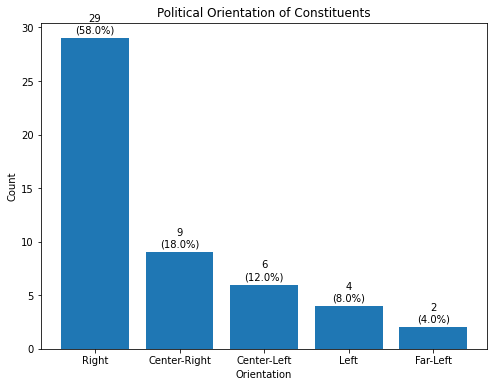

In [183]:
import matplotlib.pyplot as plt
import numpy as np

# Get the value counts for Orientacion column
orientacion_counts = df_constitucionales[~(df_constitucionales.Electo=='')].Orientacion.value_counts()

# Create a bar chart
fig, ax = plt.subplots(figsize=(8, 6))
bars = ax.bar(orientacion_counts.index, orientacion_counts.values)

# Add value labels to each bar
for bar in bars:
    height = bar.get_height()
    ax.annotate(f"{height}\n({height/sum(orientacion_counts.values)*100:.1f}%)", 
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points", ha='center', va='bottom')

# Set the chart title and axis labels
ax.set_title("Political Orientation of Constituents")
ax.set_xlabel("Orientation")
ax.set_ylabel("Count")

plt.show()


In [188]:
# group by Partido
df_constitucionales[~(df_constitucionales.Electo=='')][['Partido','Orientacion','Lista/Pacto']]#.groupby(['Partido','Orientacion']).count().sort_values('Lista/Pacto',ascending=False)

,Partido,Orientacion,Lista/Pacto
9,REPUBLICANO,Right,DIEGO ALBERTO VARGAS CASTILLO
14,IND-PS,Center-Left,JOCELYN ORMEÑO LEE
28,REPUBLICANO,Right,NINOSKA ESTHER PAYAUNA VILCA
29,REPUBLICANO,Right,SEBASTIAN ESTEBAN PARRAGUEZ GONZALEZ
48,REPUBLICANO,Right,CARMEN MONTOYA MAYORGA
49,REPUBLICANO,Right,CARLOS SOLAR BARRIOS
53,IND-RD,Left,JOSE ANTONIO GONZALEZ PIZARRO
71,REPUBLICANO,Right,PAUL ALEXANDER SFEIR RUBIO
74,PS,Center-Left,MARCELA ALEXANDRA ARAYA SEPULVEDA
88,REPUBLICANO,Right,GLORIA YOLANDA PAREDES DIAZ
